In [1]:
#5 Modeling on training data and tested using test data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import layers, models

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:

df= pd.read_parquet(r"C:\Users\brand\UNISA_Honour_Fake_News_Program\Dataset_Merged_BackUp\ForModeling.parquet")
#ForModeling_BagofWords
#ForModeling
#ForModeling_Extra_features
df_test=pd.read_parquet(r"C:\Users\brand\UNISA_Honour_Fake_News_Program\Dataset_Merged_BackUp\ForModeling_test.parquet")
#ForModeling_BagofWords_test
#ForModeling_test

#df=df.sample(n=10000,random_state=42)
df.shape

(114561, 1013)

In [5]:
print('train data: ',df.shape)
print('test data: ',df_test.shape)

train data:  (114561, 1013)
test data:  (14583, 1013)


In [6]:
df['label'].value_counts()


label
0.0    59123
1.0    55438
Name: count, dtype: int64

In [7]:
df_test['label'].value_counts()

label
1    7295
0    7288
Name: count, dtype: int64

In [8]:
df.dropna(axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114561 entries, 96862 to 121958
Columns: 1013 entries, text to BOW_young
dtypes: float64(6), int32(2), int64(1003), object(2)
memory usage: 885.4+ MB


In [9]:

y = df['label']

# Select all columns except 'label','text','text_processed' for features
X = df.drop(columns=['label','text','text_processed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
y_clean_test=df_test['label']

X_clean_test=df_test.drop(columns=['label','text','text_processed'])

X_clean_test=scaler.fit_transform(X_clean_test)


In [11]:
print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)

print('y_clean_test: ',y_clean_test.shape)
print('X_clean_test: ',X_clean_test.shape)



X_train:  (80192, 1010)
X_test:  (34369, 1010)
y_train:  (80192,)
y_test:  (34369,)
y_clean_test:  (14583,)
X_clean_test:  (14583, 1010)


In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train the XGBoost classifier
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',
                              gpu_id=0,
                              max_depth=25,#0,inf
                             )
xgb_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


D:\Programs\envs\FakeNewsResearch\lib\site-packages\xgboost\core.py:160: UserWarning: [10:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
D:\Programs\envs\FakeNewsResearch\lib\site-packages\xgboost\core.py:160: UserWarning: [10:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
D:\Programs\envs\FakeNewsResearch\lib\site-packages\xgboost\core.py:160: UserWarning: [10:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3

Accuracy: 0.9252233117053158
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93     17813
         1.0       0.93      0.92      0.92     16556

    accuracy                           0.93     34369
   macro avg       0.93      0.92      0.93     34369
weighted avg       0.93      0.93      0.93     34369

Confusion Matrix:
[[16620  1193]
 [ 1377 15179]]


In [13]:
y_pred = xgb_model.predict(X_clean_test)

# Evaluate the model
accuracy = accuracy_score(y_clean_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_clean_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_clean_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9162037989439759
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      7288
           1       0.92      0.91      0.92      7295

    accuracy                           0.92     14583
   macro avg       0.92      0.92      0.92     14583
weighted avg       0.92      0.92      0.92     14583

Confusion Matrix:
[[6713  575]
 [ 647 6648]]


In [14]:
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
model.summary()

Epoch 1/25
1003/1003 [==============================] - 9s 6ms/step - loss: 0.6316 - accuracy: 0.6384 - val_loss: 0.3157 - val_accuracy: 0.8541
Epoch 2/25
1003/1003 [==============================] - 6s 6ms/step - loss: 0.3310 - accuracy: 0.8531 - val_loss: 0.2346 - val_accuracy: 0.8992
Epoch 3/25
1003/1003 [==============================] - 6s 5ms/step - loss: 0.2705 - accuracy: 0.8862 - val_loss: 0.2226 - val_accuracy: 0.9040
Epoch 4/25
1003/1003 [==============================] - 6s 6ms/step - loss: 0.2449 - accuracy: 0.8977 - val_loss: 0.2087 - val_accuracy: 0.9112
Epoch 5/25
1003/1003 [==============================] - 6s 6ms/step - loss: 0.2198 - accuracy: 0.9109 - val_loss: 0.2048 - val_accuracy: 0.9141
Epoch 6/25
1003/1003 [==============================] - 6s 6ms/step - loss: 0.2009 - accuracy: 0.9193 - val_loss: 0.1997 - val_accuracy: 0.9173
Epoch 7/25
1003/1003 [==============================] - 6s 6ms/step - loss: 0.1848 - accuracy: 0.9266 - val_loss: 0.1959 - val_accuracy:

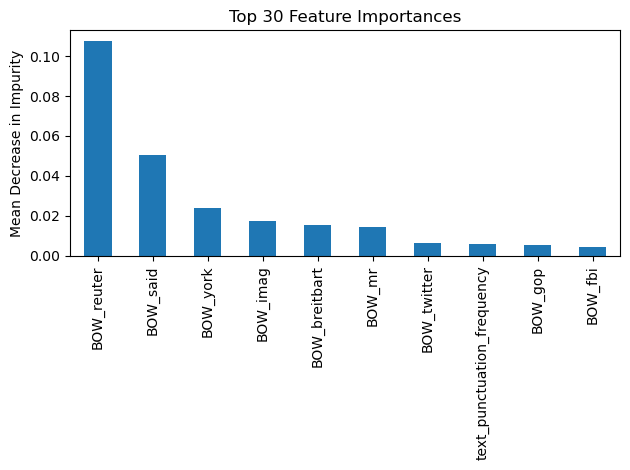

In [15]:
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_
xgb_importances = pd.Series(importances, index=X.columns)


xgb_importances_sorted = xgb_importances.sort_values(ascending=False)

# Select the top 20 features
top_20_features = xgb_importances_sorted[:10]

# Create the bar plot for the top 20 features
fig, ax = plt.subplots()
top_20_features.plot.bar(ax=ax)
ax.set_title('Top 30 Feature Importances')
ax.set_ylabel('Mean Decrease in Impurity')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
fig.tight_layout()
plt.show()

Index(['word_count', 'avg_sentence_length', 'text_punctuation_frequency',
       'text_capitalization_frequency', 'text_before_character_removal',
       'text_after_character_removal', 'subjectivity_text', 'text_sentiment',
       'text_reading_ease', 'text_lexical_diversity'],
      dtype='object')


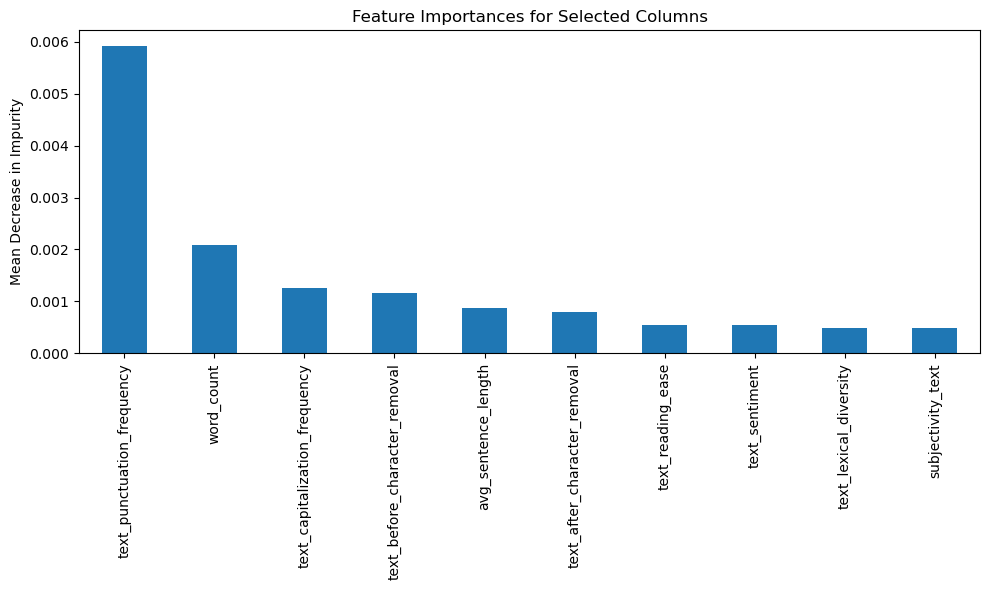

In [16]:
import matplotlib.pyplot as plt

col=X.iloc[:,:-1000].columns
print(col)

importances = xgb_model.feature_importances_
xgb_importances = pd.Series(importances, index=X.columns)

# Select the top 20 features
selected_importances = xgb_importances[col].sort_values(ascending=False)

# Create a bar plot for the selected columns' importances
fig, ax = plt.subplots(figsize=(10, 6))
selected_importances.plot.bar(ax=ax)
ax.set_title('Feature Importances for Selected Columns')
ax.set_ylabel('Mean Decrease in Impurity')
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

In [17]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)


(34369, 1010)
(80192, 1010)
(34369,)
(80192,)


In [18]:
from sklearn.preprocessing import StandardScaler


logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)  


y_pred = logistic_model.predict(X_test) 

coefficients = logistic_model.coef_
intercept = logistic_model.intercept_

# Display the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Coefficients: [[-0.98757784  4.61798493  4.0237429  ...  0.02294866  0.47960839
   0.01401358]]
Intercept: [-3.49955656]
Accuracy: 0.6926008903372225
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70     17813
         1.0       0.68      0.69      0.69     16556

    accuracy                           0.69     34369
   macro avg       0.69      0.69      0.69     34369
weighted avg       0.69      0.69      0.69     34369

Confusion Matrix:
[[12307  5506]
 [ 5059 11497]]


D:\Programs\envs\FakeNewsResearch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
y_pred = logistic_model.predict(X_clean_test)

accuracy = accuracy_score(y_clean_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_clean_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_clean_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.698004525817733
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      7288
           1       0.70      0.69      0.70      7295

    accuracy                           0.70     14583
   macro avg       0.70      0.70      0.70     14583
weighted avg       0.70      0.70      0.70     14583

Confusion Matrix:
[[5125 2163]
 [2241 5054]]


['avg_sentence_length' 'text_punctuation_frequency' 'text_reading_ease'
 'BOW_said' 'text_capitalization_frequency' 'word_count' 'BOW_got'
 'BOW_went' 'BOW_dont' 'BOW_breitbart' 'BOW_im' 'BOW_video' 'BOW_women'
 'BOW_media' 'BOW_led' 'BOW_say' 'BOW_york' 'text_after_character_removal'
 'BOW_medium' 'BOW_ad']
[ 4.61798493  4.0237429   3.84205052 -1.53636834  1.25907259 -0.98757784
  0.97665604  0.87387907 -0.77898758  0.73963816 -0.73084923 -0.69224207
  0.60362315  0.58858181 -0.55041814  0.52199276  0.47960839  0.46679851
 -0.4628519  -0.40514287]


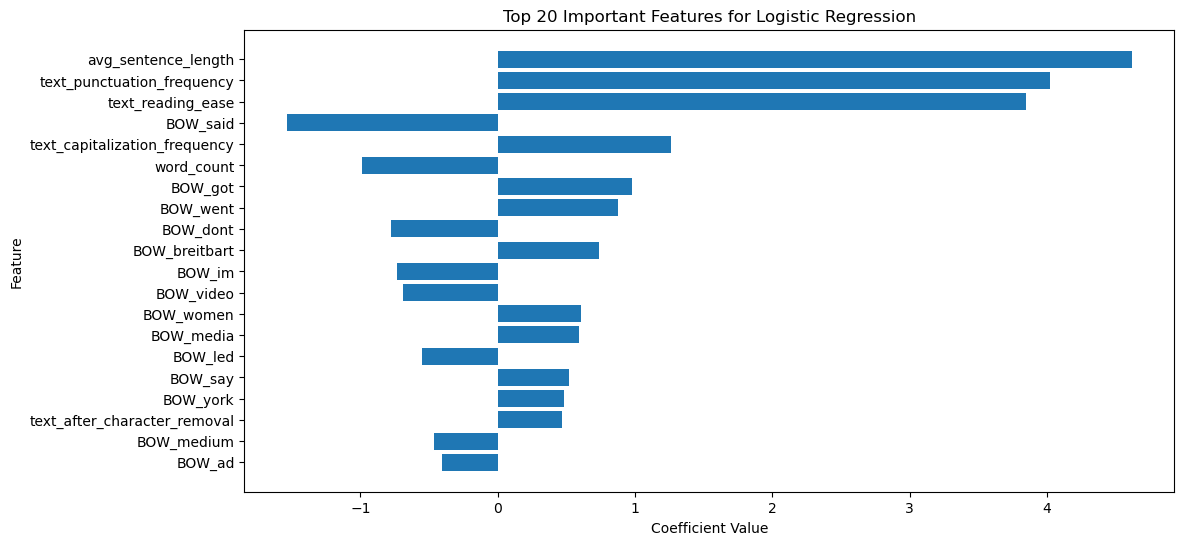

In [20]:

coefficients = logistic_model.coef_[0]

# Sort the coefficients by absolute value to find the most important features
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

# Select the top N most important features (adjust N as needed)
top_n_features = 20  # Change this to the number of top features you want to visualize

# Get the names of the top N most important features
feature_names = np.array(X.columns) 
top_features = feature_names[sorted_indices][:top_n_features]
print(top_features)
print(coefficients[sorted_indices][:top_n_features])
# Plot the coefficients of the top N most important features
plt.figure(figsize=(12, 6))
plt.barh(range(top_n_features), coefficients[sorted_indices][:top_n_features], align='center')
plt.yticks(range(top_n_features), top_features)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top {} Important Features for Logistic Regression'.format(top_n_features))
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()




In [21]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42,                                       
                                       n_estimators=100, 
                                       criterion='entropy', 
                                       max_features='sqrt', )

# Train the Random Forest classifier
random_forest.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8989205388576915
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     17813
         1.0       0.90      0.89      0.89     16556

    accuracy                           0.90     34369
   macro avg       0.90      0.90      0.90     34369
weighted avg       0.90      0.90      0.90     34369

Confusion Matrix:
[[16239  1574]
 [ 1900 14656]]


In [22]:
y_pred = random_forest.predict(X_clean_test)

# Calculate accuracy
accuracy = accuracy_score(y_clean_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_clean_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_clean_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8725228005211547
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      7288
           1       0.87      0.87      0.87      7295

    accuracy                           0.87     14583
   macro avg       0.87      0.87      0.87     14583
weighted avg       0.87      0.87      0.87     14583

Confusion Matrix:
[[6377  911]
 [ 948 6347]]


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout


# Create a neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# Make predictions on the test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/10
1253/1253 [==============================] - 3s 2ms/step - loss: 0.4960 - accuracy: 0.7222
Epoch 2/10
1253/1253 [==============================] - 2s 2ms/step - loss: 0.3172 - accuracy: 0.8616
Epoch 3/10
1253/1253 [==============================] - 2s 2ms/step - loss: 0.2729 - accuracy: 0.8843
Epoch 4/10
1253/1253 [==============================] - 2s 2ms/step - loss: 0.2490 - accuracy: 0.8958
Epoch 5/10
1253/1253 [==============================] - 3s 2ms/step - loss: 0.2316 - accuracy: 0.9043
Epoch 6/10
1253/1253 [==============================] - 2s 2ms/step - loss: 0.2212 - accuracy: 0.9079
Epoch 7/10
1253/1253 [==============================] - 2s 2ms/step - loss: 0.2099 - accuracy: 0.9141
Epoch 8/10
1253/1253 [==============================] - 2s 2ms/step - loss: 0.2035 - accuracy: 0.9165
Epoch 9/10
1253/1253 [==============================] - 2s 2ms/step - loss: 0.1942 - accuracy: 0.9219
Epoch 10/10
1075/1075 [==============================] - 1s 852us/step
Accuracy: 0

In [24]:
y_pred = (model.predict(X_clean_test) > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(y_clean_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_clean_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_clean_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


456/456 [==============================] - 0s 855us/step
Accuracy: 0.932592744977028
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      7288
           1       0.95      0.92      0.93      7295

    accuracy                           0.93     14583
   macro avg       0.93      0.93      0.93     14583
weighted avg       0.93      0.93      0.93     14583

Confusion Matrix:
[[6908  380]
 [ 603 6692]]


In [25]:
from sklearn.tree import DecisionTreeClassifier

# Create and train the Decision Tree classifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8724140940964241
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     17813
         1.0       0.87      0.87      0.87     16556

    accuracy                           0.87     34369
   macro avg       0.87      0.87      0.87     34369
weighted avg       0.87      0.87      0.87     34369

Confusion Matrix:
[[15613  2200]
 [ 2185 14371]]


In [26]:
y_pred = dt_model.predict(X_clean_test)

# Evaluate the model
accuracy = accuracy_score(y_clean_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_clean_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_clean_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7972296509634506
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      7288
           1       0.77      0.84      0.81      7295

    accuracy                           0.80     14583
   macro avg       0.80      0.80      0.80     14583
weighted avg       0.80      0.80      0.80     14583

Confusion Matrix:
[[5479 1809]
 [1148 6147]]


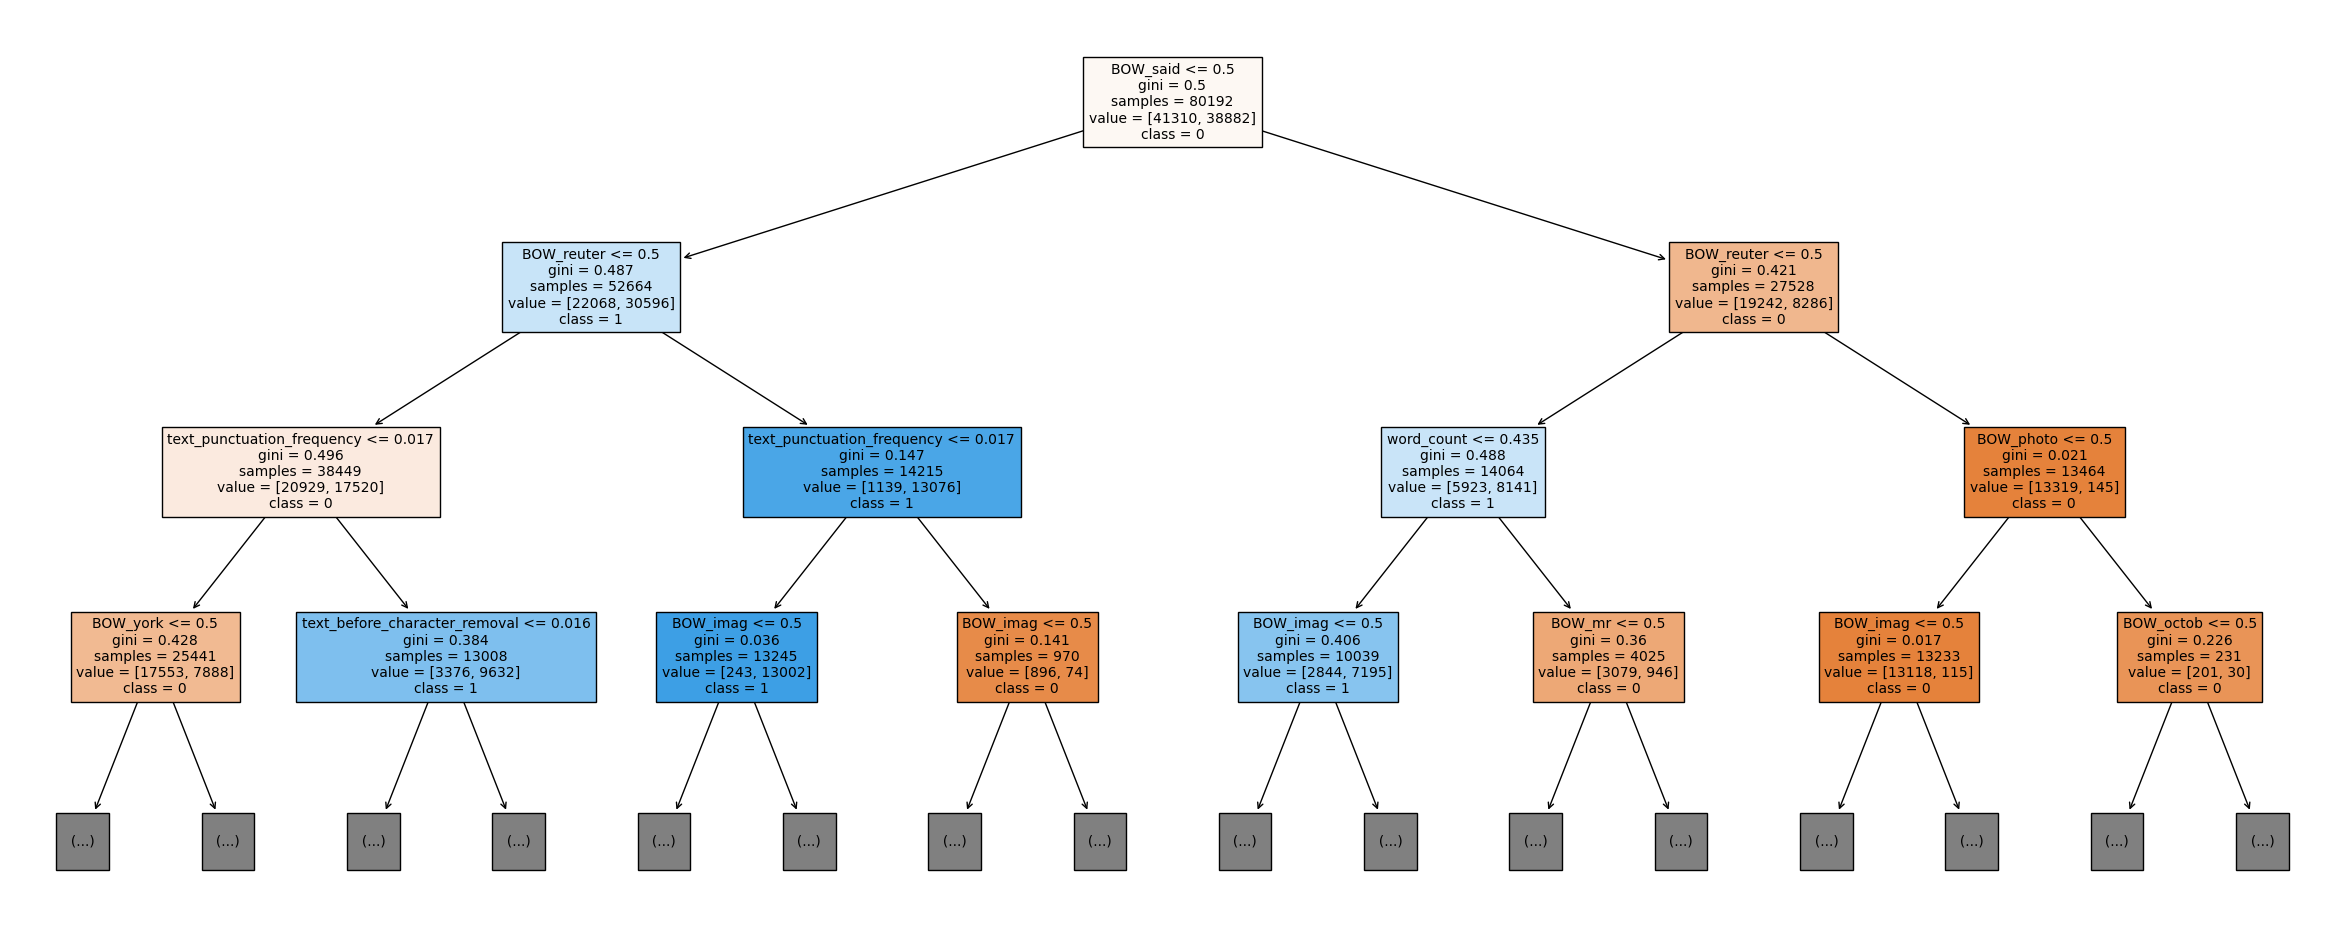

In [27]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Increase max_depth to display a deeper tree
plt.figure(figsize=(30, 12))
plot_tree(dt_model, max_depth=3, fontsize=10, feature_names=X.columns.tolist(), 
          class_names=['0', '1'], filled=True, node_ids=False)
plt.show()


In [28]:
import lightgbm as lgb

# Define and train LightGBM classifier
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(X_train, y_train)

# Predict on test set
y_pred = lgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

y_pred = lgb_classifier.predict(X_clean_test)

# Calculate accuracy
accuracy = accuracy_score(y_clean_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_clean_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_clean_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

[LightGBM] [Info] Number of positive: 38882, number of negative: 41310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4266
[LightGBM] [Info] Number of data points in the train set: 80192, number of used features: 1010
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484861 -> initscore=-0.060573
[LightGBM] [Info] Start training from score -0.060573
Accuracy: 0.9092787104658268
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91     17813
         1.0       0.91      0.90      0.91     16556

    accuracy                           0.91     34369
   macro avg       0.91      0.91      0.91     34369
weighted avg       0.91      0.91      0.91     34369

Confusion Matrix:
[[16368  1445]
 [ 1673 14883]]
Accuracy: 0.9016663238016869
      

In [29]:
from catboost import CatBoostClassifier

# Define and train CatBoost classifier
catboost_classifier = CatBoostClassifier()
catboost_classifier.fit(X_train, y_train)

# Predict on test set
y_pred = catboost_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

y_pred = catboost_classifier.predict(X_clean_test)

# Calculate accuracy
accuracy = accuracy_score(y_clean_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_clean_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_clean_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Learning rate set to 0.066988
0:	learn: 0.6246474	total: 116ms	remaining: 1m 56s
1:	learn: 0.5756753	total: 151ms	remaining: 1m 15s
2:	learn: 0.5314743	total: 186ms	remaining: 1m 1s
3:	learn: 0.4953287	total: 224ms	remaining: 55.7s
4:	learn: 0.4699693	total: 258ms	remaining: 51.3s
5:	learn: 0.4478913	total: 292ms	remaining: 48.3s
6:	learn: 0.4299982	total: 327ms	remaining: 46.3s
7:	learn: 0.4147464	total: 363ms	remaining: 45s
8:	learn: 0.4015212	total: 400ms	remaining: 44.1s
9:	learn: 0.3922054	total: 439ms	remaining: 43.5s
10:	learn: 0.3824457	total: 480ms	remaining: 43.2s
11:	learn: 0.3768940	total: 517ms	remaining: 42.6s
12:	learn: 0.3699192	total: 554ms	remaining: 42.1s
13:	learn: 0.3623786	total: 592ms	remaining: 41.7s
14:	learn: 0.3579367	total: 633ms	remaining: 41.6s
15:	learn: 0.3527998	total: 705ms	remaining: 43.4s
16:	learn: 0.3478941	total: 750ms	remaining: 43.4s
17:	learn: 0.3437892	total: 788ms	remaining: 43s
18:	learn: 0.3390492	total: 828ms	remaining: 42.8s
19:	learn: 0.